# Implementation of siamese nueral network :-3
*  Applied siamese NN on MNIST dataset.

*  10 random samples of every class are used.

*  Added NN embeddings visualisation.

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O.

# Input data files are available in the "../input/" directory.

import os
print(os.listdir("./input"))

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')


['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:

from __future__ import absolute_import
from __future__ import print_function

import random
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 10


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):

    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):

    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):

    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
 
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):

    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

Using TensorFlow backend.


In [3]:
# load and reshape data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

train_labels =train['label']
train_images =train.drop(['label'],axis=1)

train_data = np.array(train_images).reshape(-1,28,28)
train_label = np.array(train_labels)
test_x = np.array(test).reshape(-1,28,28)

In [4]:
# the data, split between train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, shuffle=True, random_state=1)
print("Train data shape: {}.".format(x_train.shape))
print("Test data shape {}.".format(test_x.shape))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
test_x = test_x/255
input_shape = x_train.shape[1:]

Train data shape: (33600, 28, 28).
Test data shape (28000, 28, 28).


In [5]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]

tr_pairs, tr_y = create_pairs(x_train, digit_indices)
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [6]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
#rms = Adam()
#rms = SGD()

model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
# train
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_te)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 61260 samples, validate on 14600 samples
Epoch 1/10
61260/61260 [==============================] - 6s 91us/step - loss: 0.0901 - accuracy: 0.8900 - val_loss: 0.0457 - val_accuracy: 0.9455
Epoch 2/10
61260/61260 [==============================] - 3s 43us/step - loss: 0.0390 - accuracy: 0.9570 - val_loss: 0.0324 - val_accuracy: 0.9592
Epoch 3/10
61260/61260 [==============================] - 3s 45us/step - loss: 0.0262 - accuracy: 0.9720 - val_loss: 0.0276 - val_accuracy: 0.9664
Epoch 4/10
61260/61260 [==============================] - 3s 44us/step - loss: 0.0194 - accuracy: 0.9798 - val_loss: 0.0261 - val_accuracy: 0.9686
Epoch 5/10
61260/61260 [==============================] - 3s 44us/step - loss: 0.0160 - accuracy: 0.9821 - val_loss: 0.0248 - v

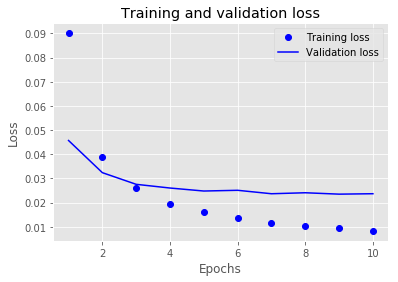

In [7]:
# LOSS Learning curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

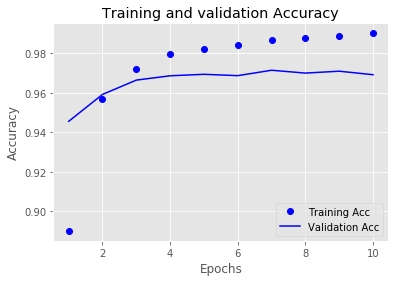

In [8]:
# ACCURACY Learning Curves

history_dict = history.history
loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']
epochs = range(1, (len(history.history['accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training Acc')
plt.plot(epochs, val_loss_values, 'b', label='Validation Acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
# create test pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
example_numbers = 10
example_indexes = [np.random.choice((digit_indices[i]), example_numbers, replace=False) for i in range(len(digit_indices))]

In [10]:
predictions =[]
for sub in range(0,len(test_x)):
    image_sub = test_x[sub].reshape(1,28,28)
    pred_sum = []
    for i in range(0,num_classes):
        raw_prediction = []
        for exam in range(0,example_numbers):
            example_image = x_train[example_indexes[i][exam]].reshape(1,28,28)
            prd = np.squeeze(model.predict([image_sub,example_image]))
            raw_prediction.append(prd)
        pred_sum.append(sum(raw_prediction)) 
    prediction = [np.argmin(pred_sum),min(pred_sum)]
    predictions.append(prediction[0])

In [11]:
# SUBMISSION
sample_submission = pd.read_csv('../input/sample_submission.csv')
#print(sample_submission.shape)
result=pd.DataFrame({'ImageId':sample_submission.ImageId, 'Label':predictions})
result.to_csv("submission.csv",index=False)
print(result)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
5            6      7
6            7      0
7            8      3
8            9      0
9           10      3
10          11      5
11          12      7
12          13      4
13          14      0
14          15      4
15          16      3
16          17      3
17          18      1
18          19      9
19          20      0
20          21      9
21          22      1
22          23      1
23          24      5
24          25      7
25          26      4
26          27      2
27          28      7
28          29      4
29          30      7
...        ...    ...
27970    27971      5
27971    27972      0
27972    27973      4
27973    27974      8
27974    27975      0
27975    27976      3
27976    27977      6
27977    27978      0
27978    27979      1
27979    27980      9
27980    27981      3
27981    27982      1
27982    27983      1
27983    2

In [12]:
# Plot the representation learned from the siamese network
embeddings = base_network.predict(x_train)

In [13]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,random_state=10).fit_transform(embeddings)

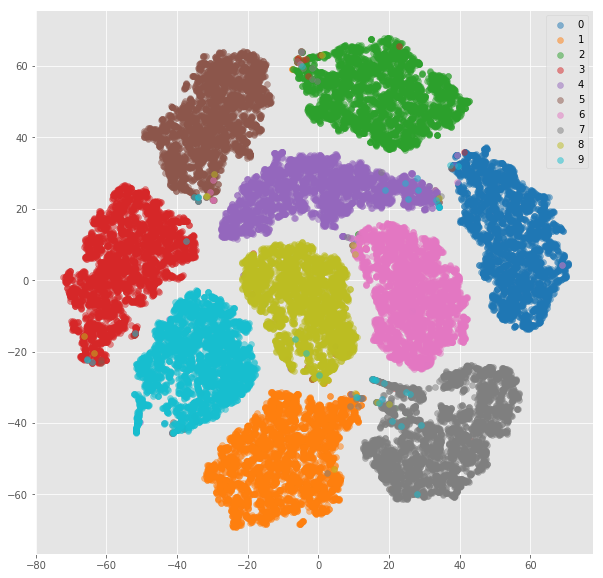

In [14]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

plt.figure(figsize=(10,10))
for i in range(10):
    inds = np.where(y_train==i)[0]
    plt.scatter(X_embedded[inds,0], X_embedded[inds,1], alpha=0.5, color=colors[i])
plt.legend(mnist_classes)